## Backward Particle Tracking, Quad-Refined Grid, Steady-State Flow

Application of a MODFLOW 6 particle-tracking (PRT) model
and a MODPATH 7 (MP7) model to solve example 2 from the
MODPATH 7 documentation.

This example problem adapts the flow system in example 1,
consisting of two aquifers separated by a low conductivity
confining layer, with an unstructured grid with a quad-
refined region around the central well. A river still runs
along the grid's right-hand boundary.

In part A, 16 particles are distributed evenly for release
around the four horizontal faces of the well. To determine
recharge points, particles are then tracked backwards to
the water table.

In part B, 100 particles are evenly distributed in a 10 x 10
square over the horizontal faces of the well, with 16 more
release points on the well cell's top face. Particles are
again tracked backwards to determine the well's capture area.


### Initial setup

Import dependencies, define the example name and workspace,
and read settings from environment variables.

In [1]:
import pathlib as pl
from pprint import pformat

import flopy
import flopy.utils.binaryfile as bf
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flopy.mf6 import MFSimulation
from flopy.plot.styles import styles
from flopy.utils.gridgen import Gridgen
from flopy.utils.gridintersect import GridIntersect
from matplotlib.lines import Line2D
from modflow_devtools.misc import get_env, timed
from shapely.geometry import LineString, MultiPoint

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-prt-mp7-p02"
# shorten model names so they fit in 16-char limit
gwf_name = sim_name.replace("ex-prt-", "") + "-gwf"
prt_name = sim_name.replace("ex-prt-", "") + "-prt"
mp7_name = sim_name.replace("ex-prt-", "") + "-mp7"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
sim_ws = workspace / sim_name
gwf_ws = sim_ws / "gwf"
prt_ws = sim_ws / "prt"
mp7_ws = sim_ws / "mp7"
gwf_ws.mkdir(exist_ok=True, parents=True)
prt_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

# Define output file names
headfile = f"{gwf_name}.hds"
budgetfile = f"{gwf_name}.cbb"
headfile_bkwd = f"{gwf_name}_bkwd.hds"
budgetfile_bkwd = f"{gwf_name}_bkwd.cbb"
budgetfile_prt = f"{prt_name}.cbb"
trackfile_prt = f"{prt_name}.trk"
trackhdrfile_prt = f"{prt_name}.trk.hdr"
trackcsvfile_prt = f"{prt_name}.trk.csv"

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 3  # Number of layers (base grid)
nrow = 21  # Number of rows (base grid)
ncol = 20  # Number of columns (base grid)
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 400.0  # Top of the model ($ft$)
botm_str = "220.0, 200.0, 0.0"  # Layer bottom elevations ($ft$)
porosity = 0.1  # Soil porosity (unitless)
rch = 0.005  # Recharge rate ($ft/d$)
kh_str = "50.0, 0.01, 200.0"  # Horizontal hydraulic conductivity ($ft/d$)
kv_str = "10.0, 0.01, 20.0"  # Vertical hydraulic conductivity ($ft/d$)
wel_q = -150000.0  # Well pumping rate ($ft^3/d$)
riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)

# Time discretization
nstp = 1
perlen = 1000.0
tsmult = 1.0
tdis_rc = [(perlen, nstp, tsmult)]

# Parse bottom elevation and horiz/vert hydraulic cond.
botm = [float(value) for value in botm_str.split(",")]
kh = [float(value) for value in kh_str.split(",")]
kv = [float(value) for value in kv_str.split(",")]

# Cell types by layer
icelltype = [1, 0, 0]

# Well
wel_coords = [(4718.45, 5281.25)]
wel_q = [-150000.0]
welcells = []

# Recharge
rch = 0.005
rch_iface = 6
rch_iflowface = -1

# River
riv_h = 320.0
riv_z = 318.0
riv_c = 1.0e5
riv_iface = 6
riv_iflowface = -1
rivcells = []


### Grid refinement

[GRIDGEN](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids) can be used to create a quadpatch grid with a central refined region.

The grid will have 3 refinement levels. First, create the top-level (base) grid discretization.

In [3]:
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Refine the grid.

In [4]:


# create Gridgen workspace
gridgen_ws = sim_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws=gridgen_ws)

# add polygon for each refinement level
outer_polygon = [[(3500, 4000), (3500, 6500), (6000, 6500), (6000, 4000), (3500, 4000)]]
g.add_refinement_features([outer_polygon], "polygon", 1, range(nlay))
refshp0 = gridgen_ws / "rf0"

middle_polygon = [
    [(4000, 4500), (4000, 6000), (5500, 6000), (5500, 4500), (4000, 4500)]
]
g.add_refinement_features([middle_polygon], "polygon", 2, range(nlay))
refshp1 = gridgen_ws / "rf1"

inner_polygon = [[(4500, 5000), (4500, 5500), (5000, 5500), (5000, 5000), (4500, 5000)]]
g.add_refinement_features([inner_polygon], "polygon", 3, range(nlay))
refshp2 = gridgen_ws / "rf2"

Build the grid and plot it with refinement levels superimposed.

In [5]:
g.build(verbose=False)
grid_props = g.get_gridprops_vertexgrid()
disv_props = g.get_gridprops_disv()
grid = flopy.discretization.VertexGrid(**grid_props)

ncpl = disv_props["ncpl"]
top = disv_props["top"]
botm = disv_props["botm"]
nvert = disv_props["nvert"]
vertices = disv_props["vertices"]
cell2d = disv_props["cell2d"]


Define particle release points for the MODPATH 7 model.

In [6]:
def get_particle_data(part):
    nodew = ncpl * 2 + welcells[0]
    if part == "A":
        pcoord = np.array(
            [
                [0.000, 0.125, 0.500],
                [0.000, 0.375, 0.500],
                [0.000, 0.625, 0.500],
                [0.000, 0.875, 0.500],
                [1.000, 0.125, 0.500],
                [1.000, 0.375, 0.500],
                [1.000, 0.625, 0.500],
                [1.000, 0.875, 0.500],
                [0.125, 0.000, 0.500],
                [0.375, 0.000, 0.500],
                [0.625, 0.000, 0.500],
                [0.875, 0.000, 0.500],
                [0.125, 1.000, 0.500],
                [0.375, 1.000, 0.500],
                [0.625, 1.000, 0.500],
                [0.875, 1.000, 0.500],
            ]
        )
        return flopy.modpath.ParticleData(
            [nodew for _ in range(pcoord.shape[0])],
            structured=False,
            localx=pcoord[:, 0],
            localy=pcoord[:, 1],
            localz=pcoord[:, 2],
            drape=0,
        )
    else:
        return flopy.modpath.NodeParticleData(
            subdivisiondata=flopy.modpath.FaceDataType(
                drape=0,
                verticaldivisions1=10,
                horizontaldivisions1=10,
                verticaldivisions2=10,
                horizontaldivisions2=10,
                verticaldivisions3=10,
                horizontaldivisions3=10,
                verticaldivisions4=10,
                horizontaldivisions4=10,
                rowdivisions5=0,
                columndivisions5=0,
                rowdivisions6=4,
                columndivisions6=4,
            ),
            nodes=nodew,
        )

-

### Model setup

Define functions to build models, write input files, and run the simulation.

In [7]:


def build_gwf_sim():
    global welcells, rivcells

    # Instantiate the MODFLOW 6 simulation object
    sim = flopy.mf6.MFSimulation(
        sim_name=gwf_name, exe_name="mf6", version="mf6", sim_ws=gwf_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.ModflowTdis(
        sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc, nper=len(tdis_rc)
    )

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=gwf_name, model_nam_file=f"{gwf_name}.nam"
    )
    gwf.name_file.save_flows = True

    # Instantiate the MODFLOW 6 gwf discretization package
    flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units=length_units,
        **disv_props,
    )

    # GridIntersect object for setting up boundary conditions
    ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)

    # Instantiate the MODFLOW 6 gwf initial conditions package
    flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=riv_h)

    # Instantiate the MODFLOW 6 gwf node property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        xt3doptions=[("xt3d")],
        icelltype=icelltype,
        k=kh,
        k33=kv,
        save_saturation=True,
        save_specific_discharge=True,
    )

    # Instantiate the MODFLOW 6 gwf recharge package
    flopy.mf6.ModflowGwfrcha(
        gwf,
        recharge=rch,
        auxiliary=["iface", "iflowface"],
        aux=[rch_iface, rch_iflowface],
    )

    # Instantiate the MODFLOW 6 gwf well package
    welcells = ix.intersects(MultiPoint(wel_coords))
    welcells = [icpl for (icpl,) in welcells]
    welspd = [[(2, icpl), wel_q[idx]] for idx, icpl in enumerate(welcells)]
    flopy.mf6.ModflowGwfwel(gwf, print_input=True, stress_period_data=welspd)

    # Instantiate the MODFLOW 6 gwf river package
    riverline = [(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]
    rivcells = ix.intersects(LineString(riverline))
    rivcells = [icpl for (icpl,) in rivcells]
    rivspd = [
        [(0, icpl), riv_h, riv_c, riv_z, riv_iface, riv_iflowface] for icpl in rivcells
    ]
    flopy.mf6.ModflowGwfriv(
        gwf, stress_period_data=rivspd, auxiliary=[("iface", "iflowface")]
    )

    # Instantiate the MODFLOW 6 gwf output control package
    headfile = f"{gwf_name}.hds"
    head_record = [headfile]
    budgetfile = f"{gwf_name}.cbb"
    budget_record = [budgetfile]
    flopy.mf6.ModflowGwfoc(
        gwf,
        pname="oc",
        budget_filerecord=budget_record,
        head_filerecord=head_record,
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    ims = flopy.mf6.ModflowIms(
        sim,
        pname="ims",
        print_option="SUMMARY",
        complexity="SIMPLE",
        outer_dvclose=1.0e-5,
        outer_maximum=100,
        under_relaxation="NONE",
        inner_maximum=100,
        inner_dvclose=1.0e-6,
        rcloserecord=0.1,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=0.99,
    )
    sim.register_ims_package(ims, [gwf.name])

    return sim


def build_prt_sim():
    global welcells, rivcells

    # Instantiate the MODFLOW 6 simulation object
    sim = flopy.mf6.MFSimulation(
        sim_name=prt_name, exe_name="mf6", version="mf6", sim_ws=prt_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.ModflowTdis(
        sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc, nper=len(tdis_rc)
    )

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        sim, modelname=prt_name, model_nam_file=f"{prt_name}.nam"
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.ModflowGwfdisv(
        prt,
        length_units=length_units,
        **disv_props,
    )

    # Instantiate the MODFLOW 6 prt model input package
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    def add_prp(part):
        prpname = f"prp2{part}"
        prpfilename = f"{prt_name}_2{part}.prp"

        # Set particle release point data according to the scenario
        releasepts = list(get_particle_data(part).to_prp(grid))

        # Instantiate the MODFLOW 6 prt particle release point (prp) package
        pd = {0: ["FIRST"], 1: []}
        flopy.mf6.ModflowPrtprp(
            prt,
            pname=prpname,
            filename=prpfilename,
            nreleasepts=len(releasepts),
            packagedata=releasepts,
            perioddata=pd,
            exit_solve_tolerance=1e-5,
            extend_tracking=True,
        )

    add_prp("A")
    add_prp("B")

    # Instantiate the MODFLOW 6 prt output control package
    budgetfile = f"{prt_name}.bud"
    trackfile = f"{prt_name}.trk"
    trackcsvfile = f"{prt_name}.trk.csv"
    budget_record = [budgetfile]
    track_record = [trackfile]
    trackcsv_record = [trackcsvfile]
    track_times = list(range(0, 72000, 1000))
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        track_filerecord=track_record,
        trackcsv_filerecord=trackcsv_record,
        ntracktimes=len(track_times),
        tracktimes=[(t,) for t in track_times],
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    # using "time-reversed" budget and head files
    pd = [
        ("GWFHEAD", pl.Path(f"../{gwf_ws.name}/{headfile_bkwd}")),
        ("GWFBUDGET", pl.Path(f"../{gwf_ws.name}/{budgetfile_bkwd}")),
    ]
    flopy.mf6.ModflowPrtfmi(prt, packagedata=pd)

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        sim,
        pname="ems",
        filename=f"{prt_name}.ems",
    )
    sim.register_solution_package(ems, [prt.name])

    return sim


def build_mp7_sim(gwf_model):
    # Create particle groups
    pga = flopy.modpath.ParticleGroup(
        particlegroupname="PG2A",
        particledata=get_particle_data("A"),
        filename="a.sloc",
    )
    pgb = flopy.modpath.ParticleGroupNodeTemplate(
        particlegroupname="PG2B",
        particledata=get_particle_data("B"),
        filename="b.sloc",
    )

    # Instantiate the MODPATH 7 simulation object
    mp7 = flopy.modpath.Modpath7(
        modelname=mp7_name,
        flowmodel=gwf_model,
        exe_name="mp7",
        model_ws=mp7_ws,
        budgetfilename=budgetfile,
        headfilename=headfile,
    )

    # Instantiate the MODPATH 7 basic data
    flopy.modpath.Modpath7Bas(mp7, porosity=porosity)

    # Instantiate the MODPATH 7 simulation data
    flopy.modpath.Modpath7Sim(
        mp7,
        simulationtype="combined",
        trackingdirection="backward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        referencetime=0.0,
        stoptimeoption="extend",
        timepointdata=[500, 1000.0],
        particlegroups=[pga, pgb],
    )

    return mp7


def build_models():
    gwf_sim = build_gwf_sim()
    prt_sim = build_prt_sim()
    mp7_sim = build_mp7_sim(gwf_sim.get_model(gwf_name))
    return gwf_sim, prt_sim, mp7_sim


def write_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            sim.write_simulation(silent=silent)
        else:
            sim.write_input()


@timed
def run_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            success, buff = sim.run_simulation(silent=silent, report=True)
        else:
            success, buff = sim.run_model(silent=silent, report=True)
        assert success, pformat(buff)

        if "gwf" in sim.name:
            # Reverse budget and head files for backward tracking
            reverse_budgetfile(gwf_ws / budgetfile, gwf_ws / budgetfile_bkwd, sim.tdis)
            reverse_headfile(gwf_ws / headfile, gwf_ws / headfile_bkwd, sim.tdis)

Because this problem tracks particles backwards, we need to reverse the head and budget files after running the groundwater flow model and before running the particle tracking model. Define functions to do this.

In [8]:


def reverse_budgetfile(fpth, rev_fpth, tdis):
    f = bf.CellBudgetFile(fpth, tdis=tdis)
    f.reverse(rev_fpth)


def reverse_headfile(fpth, rev_fpth, tdis):
    f = bf.HeadFile(fpth, tdis=tdis)
    f.reverse(rev_fpth)

Define a function to load pathline data from MODFLOW 6 PRT and MODPATH 7 pathline files.

In [9]:


def get_mf6_pathlines(path):
    # load mf6 pathlines
    mf6pl = pd.read_csv(path)

    # index by particle group and particle ID
    mf6pl.set_index(["iprp", "irpt"], drop=False, inplace=True)

    # add column mapping particle group to subproblem name (1: A, 2: B)
    mf6pl["subprob"] = mf6pl.apply(lambda row: "A" if row.iprp == 1 else "B", axis=1)

    # add release time and termination time columns
    mf6pl["t0"] = (
        mf6pl.groupby(level=["iprp", "irpt"])
        .apply(lambda x: x.t.min())
        .to_frame(name="t0")
        .t0
    )
    mf6pl["tt"] = (
        mf6pl.groupby(level=["iprp", "irpt"])
        .apply(lambda x: x.t.max())
        .to_frame(name="tt")
        .tt
    )

    # add markercolor column, color-coding by layer for plots
    mf6pl["mc"] = mf6pl.apply(
        lambda row: "green" if row.ilay == 1 else "yellow" if row.ilay == 2 else "red",
        axis=1,
    )

    return mf6pl


def get_mp7_pathlines(path, gwf_model):
    # load mp7 pathlines, letting flopy determine capture areas
    mp7plf = flopy.utils.PathlineFile(path)
    mp7pl = pd.DataFrame(
        mp7plf.get_destination_pathline_data(
            list(range(gwf_model.modelgrid.nnodes)), to_recarray=True
        )
    )

    # index by particle group and particle ID
    mp7pl.set_index(["particlegroup", "sequencenumber"], drop=False, inplace=True)

    # convert indices to 1-based (flopy converts them to 0-based, but PRT uses 1-based, so do the same for consistency)
    kijnames = [
        "k",
        "node",
        "particleid",
        "particlegroup",
        "particleidloc",
        "sequencenumber",
    ]

    for n in kijnames:
        mp7pl[n] += 1

    # add column mapping particle group to subproblem name (1: A, 2: B)
    mp7pl["subprob"] = mp7pl.apply(
        lambda row: (
            "A" if row.particlegroup == 1 else "B" if row.particlegroup == 2 else pd.NA
        ),
        axis=1,
    )

    # add release time and termination time columns
    mp7pl["t0"] = (
        mp7pl.groupby(level=["particlegroup", "sequencenumber"])
        .apply(lambda x: x.time.min())
        .to_frame(name="t0")
        .t0
    )
    mp7pl["tt"] = (
        mp7pl.groupby(level=["particlegroup", "sequencenumber"])
        .apply(lambda x: x.time.max())
        .to_frame(name="tt")
        .tt
    )

    # add markercolor column, color-coding by layer for plots
    mp7pl["mc"] = mp7pl.apply(
        lambda row: "green" if row.k == 1 else "yellow" if row.k == 2 else "red", axis=1
    )

    return mp7pl


def get_mp7_timeseries(path, gwf_model):
    # load mp7 pathlines, letting flopy determine capture areas
    mp7tsf = flopy.utils.TimeseriesFile(path)
    mp7ts = pd.DataFrame(
        mp7tsf.get_destination_timeseries_data(list(range(gwf_model.modelgrid.nnodes)))
    )

    # index by particle group and particle ID
    mp7ts.set_index(["particlegroup", "particleid"], drop=False, inplace=True)

    # convert indices to 1-based (flopy converts them to 0-based, but PRT uses 1-based, so do the same for consistency)
    kijnames = ["k", "node", "particleid", "particlegroup", "particleidloc"]

    for n in kijnames:
        mp7ts[n] += 1

    # add column mapping particle group to subproblem name (1: A, 2: B)
    mp7ts["subprob"] = mp7ts.apply(
        lambda row: (
            "A" if row.particlegroup == 1 else "B" if row.particlegroup == 2 else pd.NA
        ),
        axis=1,
    )

    # add release time and termination time columns
    mp7ts["t0"] = (
        mp7ts.groupby(level=["particlegroup", "particleid"])
        .apply(lambda x: x.time.min())
        .to_frame(name="t0")
        .t0
    )
    mp7ts["tt"] = (
        mp7ts.groupby(level=["particlegroup", "particleid"])
        .apply(lambda x: x.time.max())
        .to_frame(name="tt")
        .tt
    )

    # add markercolor column, color-coding by layer for plots
    mp7ts["mc"] = mp7ts.apply(
        lambda row: "green" if row.k == 1 else "yellow" if row.k == 2 else "red", axis=1
    )

    return mp7ts


def get_mp7_endpoints(path, gwf_model):
    # load mp7 pathlines, letting flopy determine capture areas
    mp7epf = flopy.utils.EndpointFile(path)
    mp7ep = pd.DataFrame(
        mp7epf.get_destination_endpoint_data(list(range(gwf_model.modelgrid.nnodes)))
    )

    # index by particle group and particle ID
    mp7ep.set_index(["particlegroup", "particleid"], drop=False, inplace=True)

    # convert indices to 1-based (flopy converts them to 0-based, but PRT uses 1-based, so do the same for consistency)
    kijnames = ["k", "node", "particleid", "particlegroup", "particleidloc"]

    for n in kijnames:
        mp7ep[n] += 1

    # add column mapping particle group to subproblem name (1: A, 2: B)
    mp7ep["subprob"] = mp7ep.apply(
        lambda row: (
            "A" if row.particlegroup == 1 else "B" if row.particlegroup == 2 else pd.NA
        ),
        axis=1,
    )

    # add release time and termination time columns
    mp7ep["t0"] = (
        mp7ep.groupby(level=["particlegroup", "particleid"])
        .apply(lambda x: x.time.min())
        .to_frame(name="t0")
        .t0
    )
    mp7ep["tt"] = (
        mp7ep.groupby(level=["particlegroup", "particleid"])
        .apply(lambda x: x.time.max())
        .to_frame(name="tt")
        .tt
    )

    # add markercolor column, color-coding by layer for plots
    mp7ep["mc"] = mp7ep.apply(
        lambda row: "green" if row.k == 1 else "yellow" if row.k == 2 else "red", axis=1
    )

    return mp7ep

### Plotting results

Define functions to plot model results.

In [10]:
# colormap for boundary locations
cmapbd = mpl.colors.ListedColormap(["r", "g"])

# time series point colors by layer
colors = ["green", "orange", "red"]

# figure sizes
figure_size_solo = (7, 7)
figure_size_compare = (7, 5)


def plot_nodes_and_vertices(gwf, ax):
    """
    Plot cell nodes and vertices (and IDs) on a zoomed inset
    """

    ax.set_aspect("equal")

    # set zoom area
    xmin, xmax = 2050, 4800
    ymin, ymax = 5200, 7550
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

    # create map view plot
    pmv = flopy.plot.PlotMapView(gwf, ax=ax)
    pmv.plot_grid(edgecolor="black", alpha=0.25)
    styles.heading(ax=ax, heading="Nodes and vertices (one-based)", fontsize=8)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

    # plot vertices
    mg = gwf.modelgrid
    verts = mg.verts
    ax.plot(verts[:, 0], verts[:, 1], "bo", alpha=0.25, ms=2)
    for i in range(ncpl):
        x, y = verts[i, 0], verts[i, 1]
        if xmin <= x <= xmax and ymin <= y <= ymax:
            ax.annotate(str(i + 1), verts[i, :], color="b", alpha=0.5)

    # plot nodes
    xc, yc = mg.get_xcellcenters_for_layer(0), mg.get_ycellcenters_for_layer(0)
    for i in range(ncpl):
        x, y = xc[i], yc[i]
        ax.plot(x, y, "o", color="grey", alpha=0.25, ms=2)
        if xmin <= x <= xmax and ymin <= y <= ymax:
            ax.annotate(str(i + 1), (x, y), color="grey", alpha=0.5)

    # plot well
    ax.plot(wel_coords[0][0], wel_coords[0][1], "ro")

    # adjust left margin to compensate for inset
    plt.subplots_adjust(left=0.45)

    # create legend
    ax.legend(
        handles=[
            Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label="Vertex",
                markerfacecolor="blue",
                markersize=10,
            ),
            Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label="Node",
                markerfacecolor="grey",
                markersize=10,
            ),
        ],
        loc="upper left",
    )


def plot_head(gwf, head, ibd):
    with styles.USGSPlot():
        fig = plt.figure(figsize=figure_size_solo)
        fig.tight_layout()
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        ax.set_xlim(0, Lx)
        ax.set_ylim(0, Ly)
        ilay = 2
        cint = 0.25
        hmin = head[ilay, 0, :].min()
        hmax = head[ilay, 0, :].max()
        styles.heading(ax=ax, heading=f"Head, layer {ilay + 1}")
        mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
        mm.plot_bc("WEL", plotAll=True)
        mm.plot_bc("RIV", plotAll=True, color="teal")
        mm.plot_grid(alpha=0.25)

        # create inset
        axins = ax.inset_axes([-0.8, 0.25, 0.7, 0.9])
        plot_nodes_and_vertices(gwf, axins)
        ax.indicate_inset_zoom(axins)

        pc = mm.plot_array(head[:, 0, :], edgecolor="black", alpha=0.5)
        cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
        cb.ax.set_xlabel(r"Head ($m$)")

        if ibd is not None:
            mm.plot_array(ibd, cmap=cmapbd, edgecolor="gray")

        # create legend
        ax.legend(
            handles=[
                mpl.patches.Patch(color="red", label="Well"),
                mpl.patches.Patch(color="teal", label="River"),
            ],
            loc="upper left",
        )

        levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
        cs = mm.contour_array(head[:, 0, :], colors="white", levels=levels)
        plt.clabel(cs, fmt="%.1f", colors="white", fontsize=11)

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-head")


def plot_points(ax, gwf, data):
    ax.set_aspect("equal")
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(alpha=0.25)
    return ax.scatter(data["x"], data["y"], color=data["mc"], s=3)


def plot_tracks(
    ax, gwf, title=None, ibd=None, pathlines=None, timeseries=None, endpoints=None
):
    ax.set_aspect("equal")
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    if title is not None:
        ax.set_title(title, fontsize=12)

    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(alpha=0.25)

    if ibd is not None:
        mm.plot_array(ibd, cmap=cmapbd, edgecolor="gray")

    pts = []
    if pathlines is not None:
        pts.append(
            mm.plot_pathline(
                pathlines, layer="all", colors=["blue"], lw=0.5, ms=1, alpha=0.25
            )
        )
        if timeseries is None and endpoints is None:
            plot_points(ax, gwf, pathlines[pathlines.ireason != 1])
    if timeseries is not None:
        for k in range(0, nlay - 1):
            pts.append(mm.plot_timeseries(timeseries, layer=k, lw=0, ms=1))
            plot_points(ax, gwf, timeseries)
    if endpoints is not None:
        pts.append(
            mm.plot_endpoint(endpoints, direction="ending", colorbar=False, shrink=0.25)
        )
    return pts[0] if len(pts) == 1 else pts


def plot_pathlines_and_points(gwf, mf6pl, ibd, title=None):
    fig, ax = plt.subplots(figsize=figure_size_compare)
    fig.tight_layout()

    plot_tracks(ax, gwf, ibd=ibd, pathlines=mf6pl)

    axins = ax.inset_axes([-0.88, 0.2, 0.7, 0.9])
    plot_tracks(axins, gwf, ibd=ibd, pathlines=mf6pl)
    ax.indicate_inset_zoom(axins)
    xmin, xmax = 3000, 6300
    ymin, ymax = 3500, 7000
    axins.set_xlim([xmin, xmax])
    axins.set_ylim([ymin, ymax])
    plt.subplots_adjust(left=0.55)

    ax.legend(
        title="EXPLANATION",
        handles=[
            Line2D(
                [0],
                [0],
                marker="o",
                markersize=10,
                markerfacecolor="green",
                color="w",
                lw=4,
                label="Layer 1",
            ),
            Line2D(
                [0],
                [0],
                marker="o",
                markersize=10,
                markerfacecolor="gold",
                color="w",
                lw=4,
                label="Layer 2",
            ),
            Line2D(
                [0],
                [0],
                marker="o",
                markersize=10,
                markerfacecolor="red",
                color="w",
                lw=4,
                label="Layer 3",
            ),
        ],
    )

    if title is not None:
        styles.heading(ax, title)

    if plot_show:
        plt.show()
    if plot_save:
        fig.savefig(figs_path / f"{sim_name}-paths")


def plot_2b(gwf, mf6endpoints, ibd, title=None):
    fig, ax = plt.subplots(figsize=figure_size_compare)
    pts = plot_tracks(ax, gwf, ibd=ibd, endpoints=mf6endpoints)

    if title is not None:
        styles.heading(ax, title)

    cax = fig.add_axes([0.4, 0.12, 0.2, 0.01])
    cb = plt.colorbar(pts, cax=cax, orientation="horizontal", shrink=0.25)
    cb.set_label("Travel time (days)")

    plt.subplots_adjust(bottom=0.2)

    if plot_show:
        plt.show()
    if plot_save:
        fig.savefig(figs_path / f"{sim_name}-endpts")


def plot_3d(gwf, pathlines, endpoints=None, title=None):
    import pyvista as pv
    from flopy.export.vtk import Vtk

    pv.set_plot_theme("document")
    axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)

    vert_exag = 10
    pathlines = pathlines.to_records(index=False)
    vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=False)
    vtk.add_model(gwf)
    vtk.add_pathline_points(pathlines)
    gwf_mesh, prt_mesh = vtk.to_pyvista()
    riv_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[1] - delc,
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            220 * vert_exag,
            gwf.output.head().get_data()[(0, 0, ncol - 1)] * vert_exag,
        ]
    )
    wel_mesh = pv.Box(bounds=(4700, 4800, 5200, 5300, 0, 200 * vert_exag))
    bed_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[0],
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            200 * vert_exag,
            220 * vert_exag,
        ]
    )
    gwf_mesh.rotate_z(-30, point=axes.origin, inplace=True)
    gwf_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    gwf_mesh.rotate_x(10, point=axes.origin, inplace=True)
    prt_mesh.rotate_z(-30, point=axes.origin, inplace=True)
    prt_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    prt_mesh.rotate_x(10, point=axes.origin, inplace=True)
    riv_mesh.rotate_z(-30, point=axes.origin, inplace=True)
    riv_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    riv_mesh.rotate_x(10, point=axes.origin, inplace=True)
    wel_mesh.rotate_z(-30, point=axes.origin, inplace=True)
    wel_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    wel_mesh.rotate_x(10, point=axes.origin, inplace=True)
    bed_mesh.rotate_z(-30, point=axes.origin, inplace=True)
    bed_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    bed_mesh.rotate_x(10, point=axes.origin, inplace=True)

    plot_endpoints = False
    if endpoints is not None:
        plot_endpoints = True
        endpoints = endpoints.to_records(index=False)
        endpoints["z"] = endpoints["z"] * vert_exag
        eps_mesh = pv.PolyData(np.array(tuple(map(tuple, endpoints[["x", "y", "z"]]))))
        eps_mesh.rotate_z(-30, point=axes.origin, inplace=True)
        eps_mesh.rotate_y(-10, point=axes.origin, inplace=True)
        eps_mesh.rotate_x(10, point=axes.origin, inplace=True)

    def _plot(screenshot=False):
        p = pv.Plotter(
            window_size=[500, 500],
            off_screen=screenshot,
            notebook=False if screenshot else None,
        )
        p.enable_anti_aliasing()
        if title is not None:
            p.add_title(title, font_size=7)
        p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
        p.add_mesh(
            prt_mesh,
            scalars="k" if "k" in prt_mesh.point_data else "ilay",
            cmap=["green", "gold", "red"],
            point_size=4,
            line_width=3,
            render_points_as_spheres=True,
            render_lines_as_tubes=True,
            smooth_shading=True,
        )
        p.remove_scalar_bar()
        if plot_endpoints:
            p.add_mesh(
                eps_mesh,
                scalars=endpoints.k.ravel(),
                cmap=["green", "gold", "red"],
                point_size=4,
            )
            p.remove_scalar_bar()
        p.add_mesh(riv_mesh, color="teal", opacity=0.2)
        p.add_mesh(wel_mesh, color="red", opacity=0.3)
        p.add_mesh(bed_mesh, color="tan", opacity=0.1)
        p.add_legend(
            labels=[("Layer 1", "green"), ("Layer 2", "gold"), ("Layer 3", "red")],
            bcolor="white",
            face="r",
            size=(0.15, 0.15),
        )

        p.camera.zoom(2)
        p.show()
        if screenshot:
            p.screenshot(figs_path / f"{sim_name}-paths-3d.png")

    if plot_show:
        _plot()
    if plot_save:
        _plot(screenshot=True)


def load_head():
    head_file = flopy.utils.HeadFile(gwf_ws / (gwf_name + ".hds"))
    return head_file.get_data()


def get_ibound():
    ibd = np.zeros((ncpl), dtype=int)
    ibd[np.array(welcells)] = 1
    ibd[np.array(rivcells)] = 2
    return np.ma.masked_equal(ibd, 0)


def plot_results(gwf_sim):
    gwf_model = gwf_sim.get_model(gwf_name)
    ibound = get_ibound()
    mf6pl = get_mf6_pathlines(prt_ws / trackcsvfile_prt)
    mf6ep = mf6pl[mf6pl.ireason == 3]  # termination event
    mp7pl = get_mp7_pathlines(mp7_ws / f"{mp7_name}.mppth", gwf_model)
    mp7ts = get_mp7_timeseries(mp7_ws / f"{mp7_name}.timeseries", gwf_model)
    mp7ep = get_mp7_endpoints(mp7_ws / f"{mp7_name}.mpend", gwf_model)

    # plot_head(gwf_model, load_head(), ibound)
    plot_pathlines_and_points(
        gwf_model,
        mf6pl=mf6pl[mf6pl.subprob == "A"],
        title="Pathlines and points (2A), 1000-day\ntime interval, colored by layer",
        ibd=ibound,
    )
    plot_3d(
        gwf_model,
        pathlines=mp7pl[mp7pl.subprob == "A"],
        endpoints=mp7ep,
        title="Pathlines (2A) and\nrecharge points (2B),\ncolored by layer",
    )
    plot_2b(
        gwf_model,
        mf6endpoints=mf6ep[mf6ep.subprob == "B"],
        title="Recharge points (2B), colored by travel time",
        ibd=ibound,
    )

### Running the example

Define and invoke a function to run the example scenario, then plot results.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model mp7-p02-gwf...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model mp7-p02-prt...
    writing model name file...
    writing package disv...
    writing package mip...
    writing package prp2a...
    writing package prp2b...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the m

    Solving:  Stress period:     1    Time step:     1

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/02/08 12:49:45
 Elapsed run time:  0.094 Seconds

 Normal termination of simulation.
FloPy is using the following executable to run the model: ../../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/07/2025
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Feb  8 2025 12:33:09 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release 


 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/02/08 12:49:45
 Elapsed run time:  0.122 Seconds

 Normal termination of simulation.
FloPy is using the following executable to run the model: ../../../../../../../.local/bin/modflow/mp7

MODPATH Version 7.2.001   
Program compiled Dec 31 2024 17:11:39 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
       432 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unrel

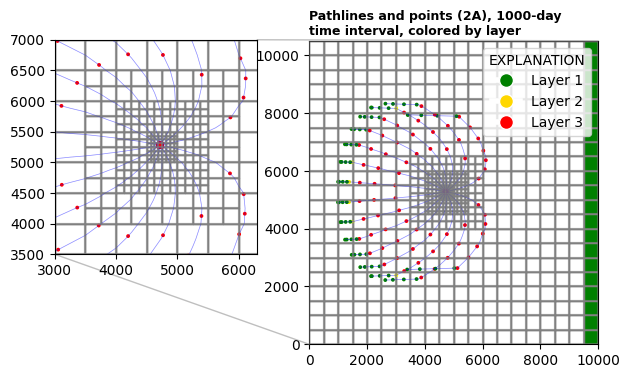

/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


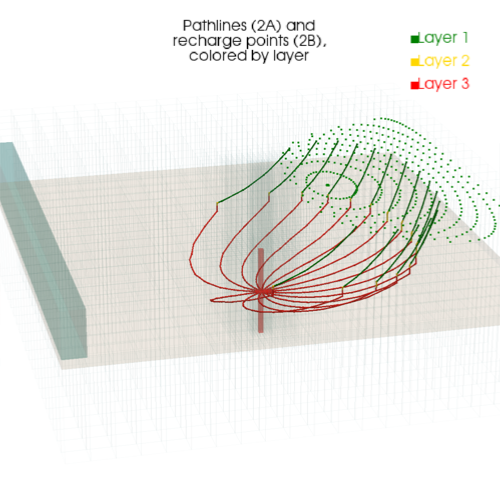

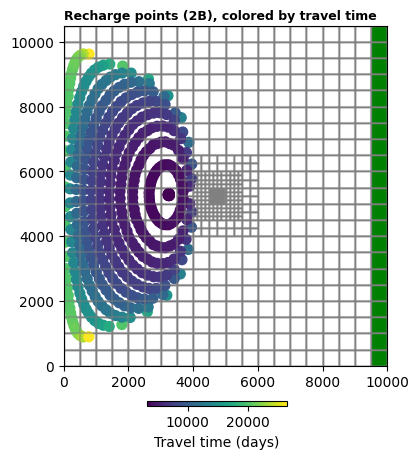

In [11]:
def scenario(silent=False):
    gwf_sim, prt_sim, mp7_sim = build_models()
    if write:
        write_models(gwf_sim, prt_sim, mp7_sim, silent=silent)
    if run:
        run_models(gwf_sim, prt_sim, mp7_sim, silent=silent)
    if plot:
        plot_results(gwf_sim)


# We are now ready to run the example problem. Subproblems 2A and 2B are solved by a single MODFLOW 6 run and a single MODPATH 7 run, so they are included under one "scenario". Each of the two subproblems is represented by its own particle release package (for MODFLOW 6) or particle group (for MODPATH 7).
scenario()